In [1]:
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

from flair.models import TextClassifier
from flair.data import Sentence

In [2]:
df = pd.read_csv('./merged_data.csv')
df

,id,date,tweet,tidyTweet
0,1484309873059934208,2022-01-20 15:40:25,@77WABCradio @RudyGiuliani I suppose all the e...,"I suppose all the election fraud, the Biden ..."
1,1484309738808840192,2022-01-20 15:39:53,The press had a lot of questions about Ukraine...,The press had a lot of questions about Ukraine...
2,1484309298867933186,2022-01-20 15:38:08,"Nevada, vote for the candidate who has the rig...","Nevada, vote for the candidate who has the rig..."
3,1484307683532754944,2022-01-20 15:31:43,@POTUS PLEASE TAKE ACTION AND ABOLISH YOUR TRU...,PLEASE TAKE ACTION AND ABOLISH YOUR TRUTH IN ...
4,1484306314432032768,2022-01-20 15:26:17,#Trump Backs Banning #NancyPelosi from #StockT...,#Trump Backs Banning #NancyPelosi from #StockT...
...,...,...,...,...
12084,1502623553891741701,2022-03-12 04:32:27,@MusicManVA 🐸🐷 Missing❗️ 🌸 #WheresFauci??? ...,🐸🐷 Missing❗️ 🌸 #WheresFauci??? 😆
12085,1502623511592173570,2022-03-12 04:32:17,🐸🐷 Missing❗️ 🌸 #WheresFauci??? 😆 https://...,🐸🐷 Missing❗️ 🌸 #WheresFauci??? 😆
12086,1502621900618489856,2022-03-12 04:25:53,#WheresFauci ?? His stubby little fingerprin...,#WheresFauci ?? His stubby little fingerprin...
12087,1502607009652293634,2022-03-12 03:26:42,good morning...#WheresFauci,good morning...#WheresFauci


In [3]:
lemmatizer = WordNetLemmatizer()
stopword = set(stopwords.words('english'))
sia = TextClassifier.load('en-sentiment')

2022-04-01 09:11:48,462 loading file C:\Users\wslin\.flair\models\sentiment-en-mix-distillbert_4.pt


In [4]:
def clean_tweet(s):
    s = str(s).lower()
    url_pattern = re.compile(r'https?://\S+')
    no_url = url_pattern.sub(r'', s)
    username_pattern = re.compile(r'@\w+')
    no_username = username_pattern.sub(r'', no_url)
    hashtag_pattern = re.compile(r'#')
    no_hashtag = hashtag_pattern.sub(r'', no_username)
    punct_pattern = re.compile(r'[^\w\s\']')
    no_punct = punct_pattern.sub(r'', no_hashtag)
    amp_pattern = re.compile(r'&amp;')
    tidy_tweet = amp_pattern.sub(r'and', no_punct)
    return tidy_tweet

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def normalize_words(tokens):
    norm_tokens = [lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return norm_tokens

def remove_stopwords(tokens):
    result_tokens = []
    for t in tokens:
        if (t not in stopword and len(t) > 2 and not t.isnumeric() and t.isalpha()):
            result_tokens.append(t)
    return result_tokens

def combine_tokens(tokens): 
    non_tokenized = ' '.join([t for t in tokens])
    return non_tokenized

def tweets_preprocessing(tweet):
    tidy_tweet = clean_tweet(tweet)
    tokens = nltk.word_tokenize(tidy_tweet)
    norm_tokens = normalize_words(tokens)
    result_tokens = remove_stopwords(norm_tokens)
    non_tokenized = combine_tokens(result_tokens)
    return non_tokenized

In [5]:
df['tidyTweet'] = df['tweet'].apply(tweets_preprocessing)

In [6]:
def sentiment_Flair_score(tweet):
    sentence = Sentence(tweet)
    sia.predict(sentence)
    if 'NEGATIVE' in str(sentence.labels[0]):
        score = -(sentence.labels[0].score)
    else:
        score = sentence.labels[0].score
    return score

def sentiment_Vader_score(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    compound_score = score['compound']
    return compound_score

def sentiment_analysis(score):
    if score >= 0:
        return 'positive'
    else:
        return 'negative'

In [7]:
df['flair_score'] = df['tidyTweet'].apply(sentiment_Flair_score)
df['sentiment_flair'] = df['flair_score'].apply(sentiment_analysis)

df['vader_score'] = df['tidyTweet'].apply(sentiment_Vader_score)
df['sentiment_vader'] = df['vader_score'].apply(sentiment_analysis)

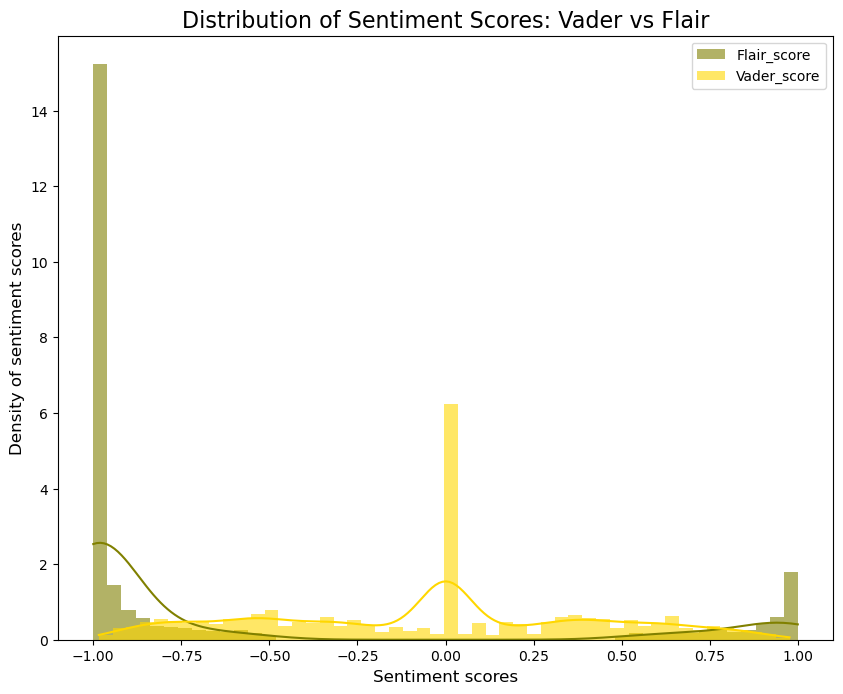

In [8]:
plt.figure(figsize = [10,8],dpi=100)
sns.histplot(df['flair_score'], kde=True, color="olive", stat="density", bins=50, alpha=0.6, linewidth=0, label='Flair_score')
sns.histplot(df['vader_score'], kde=True, color="gold", stat="density", bins=50, alpha=0.6, linewidth=0, label='Vader_score')
plt.legend(fontsize=10)
plt.title('Distribution of Sentiment Scores: Vader vs Flair', fontsize=16)
plt.ylabel('Density of sentiment scores', fontsize=12)
plt.xlabel('Sentiment scores', fontsize=12)
plt.show()

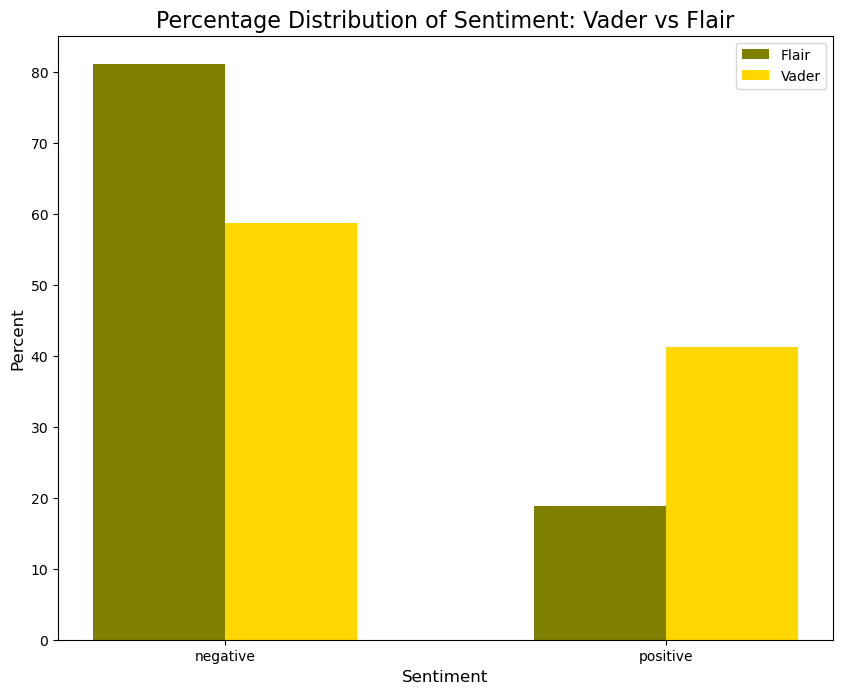

In [9]:
flair_percent = (df['sentiment_flair'].value_counts()/len(df['sentiment_flair']))*100
vader_percent = (df['sentiment_vader'].value_counts()/len(df['sentiment_vader']))*100

plt.figure(figsize=[10,8],dpi=100)
x_axis = np.arange(2)

plt.bar(x_axis-0.15, flair_percent, label='Flair', width=0.3, color='olive')
plt.bar(x_axis+0.15, vader_percent, label='Vader', width=0.3, color='gold')

plt.xticks(x_axis, df['sentiment_flair'].value_counts().index)
plt.legend(fontsize=10)
plt.title('Percentage Distribution of Sentiment: Vader vs Flair', fontsize=16)
plt.ylabel('Percent', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.show()

In [200]:
df['date'] = pd.to_datetime(df['date'])
df['dateonly'] = df['date'].apply(lambda x: x.normalize())
#df['dateonly'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['dateonly'] = pd.to_datetime(df['dateonly'])

In [201]:
df_vader = df[['dateonly', 'sentiment_vader']]
df_vader = df_vader.set_index('dateonly').groupby([pd.Grouper(freq='4D'), 'sentiment_vader'])['sentiment_vader'].count().rename("counts")
df_vader = 100*df_vader / df_vader.groupby(level=0).sum()
df_vader = df_vader.unstack(level =1).reset_index()
df_vader = df_vader.melt('dateonly', var_name='sentiment_vader', value_name='percentage')
df_vader['dateonly'] = df_vader['dateonly'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [214]:
df_flair = df[['dateonly', 'sentiment_flair']]
df_flair = df_flair.set_index('dateonly').groupby([pd.Grouper(freq='4D'), 'sentiment_flair'])['sentiment_flair'].count().rename("counts")
df_flair = 100*df_flair / df_flair.groupby(level=0).sum()
df_flair = df_flair.unstack(level=1).reset_index()
df_flair = df_flair.melt('dateonly', var_name='sentiment_flair', value_name='percentage')
df_flair['dateonly'] = df_flair['dateonly'].apply(lambda x: x.strftime('%Y-%m-%d'))

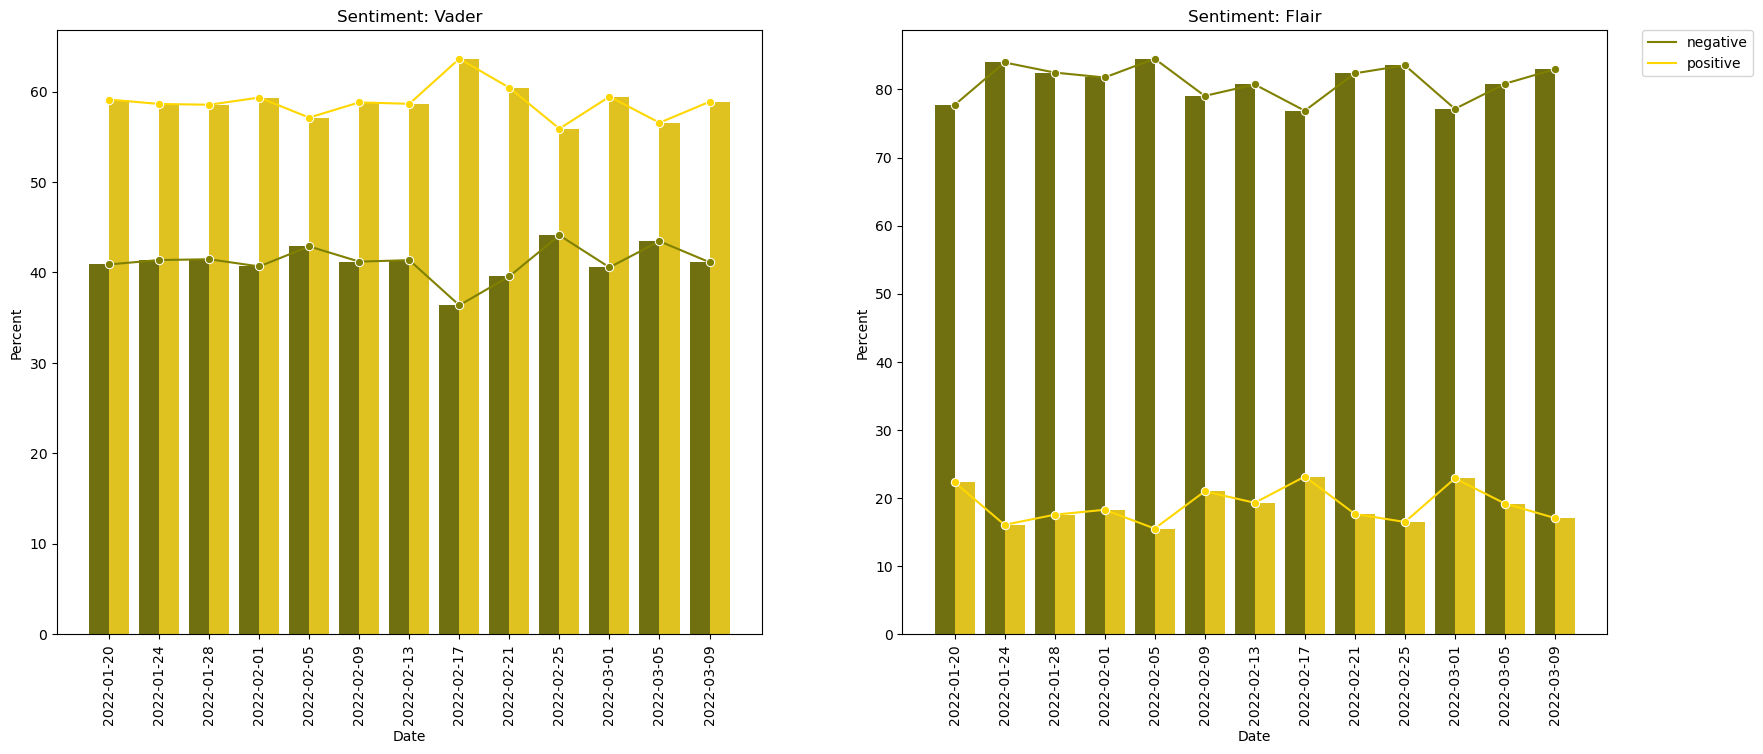

In [221]:
palette ={'negative': 'olive', 'positive': 'gold'}
fig, ax = plt.subplots(1, 2, figsize=[20,8], dpi=100)
sns.barplot(x='dateonly', y='percentage', hue='sentiment_vader', data=df_vader, palette=palette, ax=ax[0])
sns.lineplot(x='dateonly', y='percentage', data=df_vader, marker='o', hue='sentiment_vader', ax=ax[0], palette=palette)
sns.barplot(x='dateonly', y='percentage', hue='sentiment_flair', data=df_flair, palette=palette, ax=ax[1])
sns.lineplot(x='dateonly', y='percentage', data=df_flair, marker='o', hue='sentiment_flair', ax=ax[1], palette=palette)


ax[0].set_title("Sentiment: Vader")
ax[1].set_title("Sentiment: Flair")
ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')
ax[0].set_ylabel('Percent')
ax[1].set_ylabel('Percent')
ax[0].tick_params('x', labelrotation=90)
ax[1].tick_params('x', labelrotation=90)
ax[0].get_legend().remove()
handles, labels = ax[0].get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [3]:
df['diff'] = np.where(df['sentiment_flair'] == t['sentiment_vader'] , '1', '0')

NameError: name 'df' is not defined